In [1]:
import numpy as np
import ast
import urllib
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import scipy.optimize
from sklearn import linear_model # To perform logistic regression
from sklearn.preprocessing import LabelEncoder # Perform label based encoding here
from sklearn.preprocessing import OneHotEncoder # Perform one hot encoding here

In [2]:
def parseDataFromFile(fname):
    """ Read through the file and return results"""
    for l in open(fname, encoding="utf8"):
        yield ast.literal_eval(l)

In [3]:
dataset = list(parseDataFromFile("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\train.json"))
print(dataset[0])

{'hours': 0.3, 'gameID': 'b96045472', 'hours_transformed': 0.37851162325372983, 'early_access': False, 'date': '2015-04-08', 'text': '+1', 'userID': 'u01561183'}


In [4]:
print(len(dataset))
training_validation_boundary = 165000
# Here, we compute the boundaries between the training and validation set
training_set = dataset[:training_validation_boundary]
validation_set = dataset[training_validation_boundary:]

175000


In [5]:
print(training_set[0])
print(validation_set[0])
print(type(validation_set[0]))

{'hours': 0.3, 'gameID': 'b96045472', 'hours_transformed': 0.37851162325372983, 'early_access': False, 'date': '2015-04-08', 'text': '+1', 'userID': 'u01561183'}
{'hours': 5.7, 'gameID': 'b25961467', 'hours_transformed': 2.7441610955704103, 'early_access': False, 'date': '2017-11-23', 'text': 'Kerbals need you, buy this game.  Enough said.', 'userID': 'u49969792'}
<class 'dict'>


### Question 1 - Adding negative samples + Baseline Model

In [8]:
usersPerGame = defaultdict(set) # list of userIDs per game
gamesPerUser = defaultdict(set) # list of gameIDs per user
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
gameIDs = [] # This contains the entire list of games

usersPerGame_training = defaultdict(set) # list of userIDs per game
gamesPerUser_training = defaultdict(set) # list of gameIDs per user
reviewsPerUser_training = defaultdict(list)
reviewsPerGame_training = defaultdict(list)
gameIDs_training = [] # This contains the entire list of games

usersPerGame_validation = defaultdict(set) # list of userIDs per game
gamesPerUser_validation = defaultdict(set) # list of gameIDs per user
reviewsPerUser_validation = defaultdict(list)
reviewsPerGame_validation = defaultdict(list)
gameIDs_validation = [] # This contains the entire list of games

# Computing maps and lists for all samples
for d in dataset:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame[gameID].add(userID)
    gamesPerUser[userID].add(gameID)
    reviewsPerUser[userID].append(d)
    reviewsPerGame[gameID].append(d)
    if gameID not in gameIDs:
        gameIDs.append(gameID)
        
# Computing maps and lists for training set samples
for d in training_set:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame_training[gameID].add(userID)
    gamesPerUser_training[userID].add(gameID) # list of gameIDs per user
    reviewsPerUser_training[userID].append(d)
    reviewsPerGame_training[gameID].append(d)
    if gameID not in gameIDs_training:
        gameIDs_training.append(gameID)
        
# Computing maps and lists for training set samples
for d in validation_set:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame_validation[gameID].add(userID)
    gamesPerUser_validation[userID].add(gameID) # list of gameIDs per user
    reviewsPerUser_validation[userID].append(d)
    reviewsPerGame_validation[gameID].append(d)
    if gameID not in gameIDs_training:
        gameIDs_validation.append(gameID)
print("Done...")

Done...


In [18]:
# For every sample in the validation set,
# how do we compute the randomly chosen game?
new_set = []
for sample in validation_set:
    # Compute the sample (userID, gameID)
    userID, gameID = sample['userID'], sample['gameID']
    gamesNotPlayed = []
    # From the entire list of games that all users have played.
    for game in gameIDs:
        # Find all those that this user hasn't played
        if(game not in gamesPerUser[userID]):
            gamesNotPlayed.append(game)
    # By default, the following values will be used for the review
    # 'hours': -1, 'gameID': randomly chosen, 'hours_transformed': -1, 'early_access': False, 'date': '',
    # 'text': '', 'userID': userID
    # Randomly choose one game from that list of games that user hasn't played
    random.seed()
    random_gameID = random.choice(gamesNotPlayed)
    #print("For userID = {}, randomly chosen game = {}".format(userID, random_gameID))
    new_data = {'hours': 0, 'gameID': str(random_gameID),\
                'hours_transformed': 0, 'early_access': False,\
                'date': '', 'text': '', 'userID': str(userID)}
    new_set.append(new_data)
    
updated_validation_set = validation_set + new_set
print("New validation set, Old validation set lengths = {}, {}".\
      format(len(updated_validation_set), len(validation_set)))

New validation set, Old validation set lengths = 20000, 10000


### Baseline Model

In [134]:
from collections import defaultdict

def compute_performance_validation(validation_set,threshold, synthetic_sampling):
    """ Computes the performance on the validation set with the given threshold"""
    gameCount = defaultdict(int)
    totalPlayed = 0 # Total games played by users in the validation set
    
    for d in validation_set:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        
    mostPopular = [(gameCount[x],x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        mostPlayedGames.add(i)
        if(count > float(totalPlayed * threshold)): break
    
    actual_y, predicted_y, comparison = [], [], []
    # For every index in the range of the length of the validation set
    for i in range(len(validation_set)):
        # Computing actual_y
        if(synthetic_sampling):
            if i < len(validation_set)/2:
                actual_y.append(1)
            else:
                actual_y.append(0)
        else:
            # All are positive samples
            actual_y.append(1)
        # Computing predicted_y
        if validation_set[i]['gameID'] in mostPlayedGames:
            predicted_y.append(1)
        else:
            predicted_y.append(0)
        # Comparing them    
        if(predicted_y[i] == actual_y[i]):
            comparison.append(1)
        else:
            comparison.append(0)
    
#     print("comparison, actual_y, predicted_y lengths are {}, {} and {}".\
#           format(len(comparison), len(actual_y), len(predicted_y)))
    accuracy = sum(comparison)/len(comparison)
    return accuracy
    
accuracy = compute_performance_validation(updated_validation_set, 0.5, True) # two signifies 50% threshold
accuracy_old = compute_performance_validation(validation_set, 0.5, False)
print("Accuracy of the baseline prediction on validation set is {}".format(accuracy))
print("Accuracy of the old validation set is {}".format(accuracy_old))

Accuracy of the baseline prediction on validation set is 0.6658
Accuracy of the old validation set is 0.5004


### Question 2

On the modified validation set, the maximum accuracy is 0.6739 and it occurs at a threshold of 0.36000000000000004


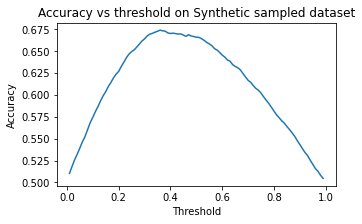

On the original validation set, the maximum accuracy is 0.9901 and it occurs at a threshold of 0.99


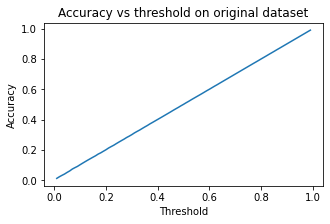

In [135]:
thresholds = [i for i in np.arange(0.01, 1, 0.01)]
#print(thresholds[:5])
accuracies = {}
for thres in thresholds:
    acc = compute_performance_validation(updated_validation_set, thres, True)
    accuracies[thres] = acc
x, y = [], []
max_acc, max_thres = -1, -1
for key, value in accuracies.items():
    x.append(key), y.append(value)
    if(value > max_acc):
        max_acc = value
        max_thres = key
print("On the modified validation set, the maximum accuracy is {} and it occurs at a threshold of {}".\
     format(max_acc, max_thres))
fig, ax = plt.subplots(figsize=(5, 3))
# Define x and y axes
ax.plot(x, y)
plt.title('Accuracy vs threshold on Synthetic sampled dataset')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

accuracies_old = {}
for thres in thresholds:
    acc = compute_performance_validation(validation_set, thres, False)
    accuracies_old[thres] = acc
x, y = [], []
max_acc, max_thres = -1, -1
for key, value in accuracies_old.items():
    x.append(key), y.append(value)
    if(value > max_acc):
        max_acc = value
        max_thres = key
print("On the original validation set, the maximum accuracy is {} and it occurs at a threshold of {}".\
     format(max_acc, max_thres))
fig_1, ax_1 = plt.subplots(figsize=(5, 3))
# Define x and y axes
ax_1.plot(x, y)
plt.title('Accuracy vs threshold on original dataset')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

A threshold value of 0.36  gives the best result for accuracy. Instead of dividing by 2, I used fractional multiples of total games played to achieve a finer sweep on the independent variable. The ideal threshold occurs at 0.36 * total games played

In [6]:
def jaccard(s1, s2):
    """ This function helps us to compute the Jaccard coefficient for the two sets S1 and S2"""
    numerator = len(s1.intersection(s2))
    denominator = len(s1.union(s2))
    return numerator/denominator

In [7]:
import math

def cosine_similarity(s1, s2):
    """ This function helps one to compute the cosine similarity"""
    numerator = len(s1.intersection(s2))
    denominator = math.sqrt(len(s1) * len(s2))
    return (numerator/denominator)

 Maximum accuracy = 0.6728, threshold = 0.030999999999999986


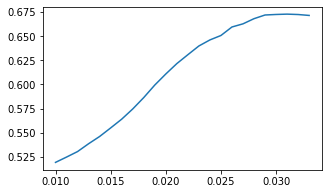

In [137]:
def similarity_based_performance(validation_set, threshold):
    idx = 0
    y_predicted, y_actual, comparison = [], [], []
    for d in validation_set:
        user, game = d['userID'], d['gameID']
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        # For every training game in the list of games
        # played by the user in the training set
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = jaccard(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        
        if(max_similarity > threshold):
            y_predicted.append(1)
        else:
            y_predicted.append(0)
                
        # This is a synthetic dataset. So, we know
        # all users in first 10000 samples have played the game
        # the remaining haven't played the game
        if(idx < len(validation_set)/2):
            y_actual.append(1)
        else:
            y_actual.append(0)
        
        if(y_actual[idx] == y_predicted[idx]):
            comparison.append(1)
        else:
            comparison.append(0)
        
        idx += 1
        
    accuracy = sum(comparison)/len(comparison)
    return accuracy

thresholds = [i for i in np.arange(0.01, 0.034, 0.001)]
accuracies = {}
for thres in thresholds:
    acc = similarity_based_performance(updated_validation_set, thres)
    accuracies[thres] = acc

x, y = [], []
max_acc, max_thres = -1, -1
for key, value in accuracies.items():
    x.append(key), y.append(value)
    if value > max_acc:
        max_thres = key
        max_acc = value
print(" Maximum accuracy = {}, threshold = {}".format(max_acc, max_thres))

fig, ax = plt.subplots(figsize=(5, 3))
# Define x and y axes
ax.plot(x, y)
plt.show()

After multiple trials with different values for the threshold, I have achieved an accuracy (0.6728) which is slightly lesser than the accuracy (0.6739) achieved using the baseline popularity based model.

### Question 4

In [141]:
def similarity_popularity_based_performance(validation_set, sim_th, pop_th):
    idx = 0
    similarities = []
    # Compute similarity based values
    for d in validation_set:
        user, game = d['userID'], d['gameID']
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        # For every training game in the list of games
        # played by the user in the training set
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = jaccard(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        similarities.append(max_similarity)
    
    gameCount = defaultdict(int)
    totalPlayed = 0 # Total games played by users in the validation set
    
    # Compute popularity based games
    for d in validation_set:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        
    mostPopular = [(gameCount[x],x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        mostPlayedGames.add(i)
        if(count > float(totalPlayed * pop_th)): break
    
    predicted_y, actual_y = [], []
    numerator, denominator = 0, 0
    for i in range(len(validation_set)):
        user, game = validation_set[i]['userID'], validation_set[i]['gameID']
        if(game in mostPlayedGames and similarities[i] > sim_th):
            predicted_y.append(1)
        else:
            predicted_y.append(0)
        
        if (i < len(validation_set) // 2):
            actual_y.append(1)
        else:
            actual_y.append(0)
    
        if (actual_y[i] == predicted_y[i]):
            numerator += 1
        denominator += 1
    
    return (numerator/denominator)
        
# Similarity and popularity based thresholds
similarity_thresholds = [i for i in np.arange(0.01, 0.04, 0.01)]
popularity_thresholds = [i for i in np.arange(0.01, 1, 0.01)]
accuracies = defaultdict(dict)
max_acc, sim_threshold, pop_threshold = -1, -1, -1
for sim_th in similarity_thresholds:
    for pop_th in popularity_thresholds:
        acc = similarity_popularity_based_performance(updated_validation_set, sim_th, pop_th)
        accuracies[sim_th][pop_th] = acc
        if(acc > max_acc):
            max_acc = acc
            sim_threshold = sim_th
            pop_threshold = pop_th

# Here, we compute the similarity and popularity thresholds
print("Maximum accuracy = {} and corresponding sim threshold, pop threshold are {} and {}".\
      format(max_acc, sim_threshold, pop_threshold))

Maximum accuracy = 0.684 and corresponding sim threshold, pop threshold are 0.03 and 0.61


### Question 5

In [25]:
def similarity_popularity_based_performance(validation_set, sim_th, pop_th):
    idx = 0
    similarities = []
    # Compute similarity based values
    for d in validation_set:
        user, game = d['userID'], d['gameID']
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        # For every training game in the list of games
        # played by the user in the training set
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = jaccard(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        similarities.append(max_similarity)
    
    gameCount = defaultdict(int)
    totalPlayed = 0 # Total games played by users in the validation set
    
    # Compute popularity based games
    for d in validation_set:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        
    mostPopular = [(gameCount[x],x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        mostPlayedGames.add(i)
        if(count > float(totalPlayed * pop_th)): break
    
    predicted_y, actual_y = [], []
    numerator, denominator = 0, 0
    for i in range(len(validation_set)):
        user, game = validation_set[i]['userID'], validation_set[i]['gameID']
        if(game in mostPlayedGames and similarities[i] > sim_th):
            predicted_y.append(1)
        else:
            predicted_y.append(0)
        
        if (i < len(validation_set) // 2):
            actual_y.append(1)
        else:
            actual_y.append(0)
    
        if (actual_y[i] == predicted_y[i]):
            numerator += 1
        denominator += 1
    
    return (numerator/denominator)

test_set = []
predictions = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = u, g
    test_set.append(val)

acc = similarity_popularity_based_performance(test_set, 0.03, 0.61)
print("Maximum accuracy = {}".format(acc))

Maximum accuracy = 0.50255


In [28]:
test_set = []
predictions = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = u, g
    test_set.append(val)

#test_set = validation_set + test_set
print("Length of the test and validation sets are {}, {}".format(len(test_set), len(validation_set)))
def similarity_popularity_based_performance(test_set, sim_th, pop_th):
    idx = 0
    similarities = []
    gameCount = defaultdict(int)
    totalPlayed = 0 # Total games played by users in the validation set
    # Compute similarity based values
    for d in test_set:
        user, game = d['userID'], d['gameID']
        # Computing popularity related values
        if game in gameIDs:
            gameCount[game] += 1
            totalPlayed += 1
        # Computing similarity related values
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        # For every training game in the list of games
        # played by the user in the training set
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = jaccard(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        similarities.append(max_similarity)
    
    
    mostPopular = [(gameCount[x],x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        mostPlayedGames.add(i)
        if(count > float(totalPlayed * pop_th)): break
    
    for i in range(len(test_set)):
        user, game = test_set[i]['userID'], test_set[i]['gameID']
        if(game in mostPlayedGames and similarities[i] > sim_th):
            predictions.write(user + '-' + game + ",1\n")
        else:
            predictions.write(user + '-' + game + ",0\n")

# Here, we compute the similarity based measures
similarity_popularity_based_performance(test_set, 0.03, 0.61)
print("Uploaded the solution on Kaggle under the username : Severus Snape")
predictions.close()

Length of the test and validation sets are 20000, 10000
Uploaded the solution on Kaggle under the username : Severus Snape


### Question 9 - Time played prediction task

In [9]:
training_validation_boundary = 165000
training_dataset = dataset[:training_validation_boundary]
validation_dataset = dataset[training_validation_boundary:]

In [10]:
import numpy as np

usersPerGame = defaultdict(set) # list of userIDs per game
gamesPerUser = defaultdict(set) # list of gameIDs per user
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
gameIDs = [] # This contains the entire list of games

dataset = training_dataset

for d in dataset:
    user, game = d['userID'], d['gameID']
    usersPerGame[game].add(user)
    gamesPerUser[user].add(game)
    reviewsPerUser[user].append(d)
    reviewsPerGame[game].append(d)
    # Inserting the gameID into the list of games
    gameIDs.append(game)

users = list(gamesPerUser.keys())
games = list(usersPerGame.keys())
numUsers = len(users)
numGames = len(games)

playPredictionMean = sum([d['hours_transformed'] for d in training_dataset]) / len(training_dataset)

alpha = playPredictionMean
userBiases = defaultdict(float)
gameBiases = defaultdict(float)
N = len(training_dataset)

# Compute the prediction for the user and game
def prediction(user, game):
    return alpha + userBiases[user] + gameBiases[game]

def unpack(theta):
    """ theta = [alpha, beta_u, beta_i]"""
    global alpha
    global userBiases
    global gameBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:numUsers+1]))
    gameBiases = dict(zip(games, theta[1+numUsers:]))

def MSE(predictions, labels):
    differences = [(x-y)**2 for x, y in zip(predictions, labels)]
    return sum(differences)/len(differences)
    
def cost(theta, labels, lamb):
    unpack(theta) 
    predictions = [prediction(d['userID'], d['gameID']) for d in dataset]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb/N * (userBiases[u] ** 2)
    for g in gameBiases:
        cost += lamb/N * (gameBiases[g] ** 2)
    return cost

def derivative(theta, labels, lamb):
    # Current values of theta are unpacked
    unpack(theta)
    # Compute deriv_alpha, deriv_beta_g and deriv_beta_u
    dalpha = 0
    dUserBiases = defaultdict(float)
    dGameBiases = defaultdict(float)
    # For sample in dataset
    for d in training_dataset:
        user, game = d['userID'], d['gameID']
        pred = prediction(user, game)
        diff = pred - d['hours_transformed']
        dalpha += 2/N * diff
        dUserBiases[user] += 2/N * diff
        dGameBiases[game] += 2/N * diff
    for u in userBiases:
        dUserBiases[u] += 2 * lamb/N * userBiases[u]
    for g in gameBiases:
        dGameBiases[g] += 2 * lamb/N * gameBiases[g]
        
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dGameBiases[g] for g in games]
    return np.array(dtheta)

print("Prediction mean for validation set is {}".format(playPredictionMean))
# Compute the play prediction mean
alwaysPredictMean = [playPredictionMean for d in validation_dataset]
labels = [d['hours_transformed'] for d in training_dataset]
mse = MSE(alwaysPredictMean, labels)
print("Always predict mean MSE is {}".format(mse))

x, f, d = scipy.optimize.fmin_l_bfgs_b(cost, [playPredictionMean] + [0.0]*(numUsers + numGames), derivative,\
                                       args = (labels, 10), iprint=100, epsilon=1e-4)
print("Optimizer done...")
# print("Estimated minima is {}".format(x))
# print("Estimated minimum value of cost function is {}".format(f))
# print("Return codes are {}".format(d))


Prediction mean for validation set is 3.7160737367374947
Always predict mean MSE is 5.239113152666103
MSE = 5.278092701060167
MSE = 5.159380409631046
MSE = 4.75125522591952
MSE = 15.455063715573454
MSE = 4.56219728837974
MSE = 4.072835644521755
MSE = 4.059828369804857
MSE = 4.009576839392328
MSE = 3.8370118130253084
MSE = 3.4902841335350656
MSE = 3.3123316530044558
MSE = 3.105647657813199
MSE = 3.0226969023856833
MSE = 2.941545854649425
MSE = 2.888259485783349
MSE = 2.8573760567152084
MSE = 2.853355921532098
MSE = 2.849598738575017
MSE = 2.851438672484217
MSE = 2.8476936589416852
MSE = 2.8414665296004684
MSE = 2.8352309361568273
MSE = 2.83104616609418
MSE = 2.8308810123674846
MSE = 2.8274494549687104
MSE = 2.828754621383335
MSE = 2.8297197865489347
MSE = 2.8293641091826593
MSE = 2.82781122772763
MSE = 2.826492202340028
MSE = 2.826012742150222
MSE = 2.826345317917372
MSE = 2.8260510304175517
MSE = 2.826057165561701
MSE = 2.826004016486386
MSE = 2.8257060973964245
MSE = 2.825417404173231

Performance of the model developed based on the update equations is as follows -

In [11]:
unpack(x)
predicted_y = [prediction(d['userID'], d['gameID']) for d in validation_dataset]
actual_y = [d['hours_transformed'] for d in validation_dataset]
mse_new = MSE(predicted_y, actual_y)
print("After performing gradient descent using the new model, MSE on validation dataset is {}".format(mse_new))

After performing gradient descent using the new model, MSE on validation dataset is 3.004774614053037


In [12]:
min_userBias, min_gameBias = 100, 100
max_userBias, max_gameBias = -1, -1
userID_minBias, userID_maxBias = " ", " "
gameID_minBias, gameID_maxBias = " ", " "
for userID, userBias in userBiases.items():
    if(userBias < min_userBias):
        min_userBias = userBias
        userID_minBias = userID
    elif(userBias > max_userBias):
        max_userBias = userBias
        userID_maxBias = userID

for gameID, gameBias in gameBiases.items():
    if(gameBias < min_gameBias):
        min_gameBias = gameBias
        gameID_minBias = gameID
    elif(gameBias > max_gameBias):
        max_gameBias = gameBias
        gameID_maxBias = gameID

print("Question 10: UserID and max userBias with largest value of userBias is {}, {}".\
     format(userID_maxBias, max_userBias))
print("Question 10: UserID and min userBias with smallest value of userBias is {}, {}".\
     format(userID_minBias, min_userBias))
print("Question 10: gameID and max gameBias with largest value of gameBias is {}, {}".\
     format(gameID_maxBias, max_gameBias))
print("Question 10: gameID and min gameBias with smallest value of gameBias is {}, {}".\
     format(gameID_minBias, min_gameBias))

Question 10: UserID and max userBias with largest value of userBias is u37339658, 4.633751958771042
Question 10: UserID and min userBias with smallest value of userBias is u79882368, -2.71537198581591
Question 10: gameID and max gameBias with largest value of gameBias is b80191205, 5.02246993058167
Question 10: gameID and min gameBias with smallest value of gameBias is b05546112, -2.497104166373016


### Question 11

For lambda = 0.001, MSE = 3.0217734857651655
For lambda = 0.01, MSE = 3.021558235521594
For lambda = 0.1, MSE = 3.0201681473486532
For lambda = 1.0, MSE = 3.008687335038025
For lambda = 10.0, MSE = 3.004774614053037
For lambda = 100.0, MSE = 3.4593363336892975
Minimum MSE = 3.004774614053037 and lamb = 10.0


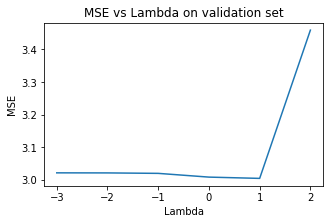

In [24]:
import matplotlib.pyplot as plt
import math

lambdas = [10 ** i for i in np.arange(-3, 3, dtype=float)]
#print(lambdas)
mse_dict = defaultdict(float)
min_mse = 10000
best_lamb = 1
for lamb in lambdas:
    labels = [d['hours_transformed'] for d in training_dataset]
    scipy.optimize.fmin_l_bfgs_b(cost,[playPredictionMean] + [0.0]*(numUsers + numGames), derivative, args = (labels, lamb))
    predicted_y = [prediction(d['userID'], d['gameID']) for d in validation_dataset]
    actual_y = [d['hours_transformed'] for d in validation_dataset]
    mse_new = MSE(predicted_y, actual_y)
    mse_dict[lamb] = mse_new
    print("For lambda = {}, MSE = {}".format(lamb, mse_new))
    if(mse_new < min_mse):
        min_mse = mse_new
        best_lamb = lamb
x, y = [], []
for key, value in mse_dict.items():
    x.append(key)
    y.append(value)

print("Minimum MSE = {} and lamb = {}".format(min_mse, best_lamb))
fig, ax = plt.subplots(figsize=(5, 3))
# Define x and y axes
x_log = [math.log10(val) for val in x]
ax.plot(x_log, y)
plt.title('MSE vs Lambda on validation set')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.show()

We know the shape of the curve that's used for computing the value of $\lambda$ using the validation set. The point where the minimum value of lambda is achieved, that's where the best MSE lies. The best value for MSE is at $\lambda$ = 10

In [13]:
# labels = [d['hours_transformed'] for d in training_dataset]
# x, f, d = scipy.optimize.fmin_l_bfgs_b(cost, [playPredictionMean] + [0.0]*(numUsers + numGames), derivative,\
#                                        args = (labels, 10), iprint=100, epsilon=1e-4)
unpack(x)
predictions = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Hours_v1.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Hours.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    pred = prediction(u, g)
    predictions.write(u + '-' + g + ',' + str(pred) + '\n')

predictions.close()

print("User name used for submission is Severus Snape")

User name used for submission is Severus Snape


### Complete latent factor model

In [8]:
dataset = list(parseDataFromFile("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\train.json"))
print(dataset[0])
print(len(dataset))
training_dataset = dataset[:165000]
validation_dataset = dataset[165000:]

{'hours': 0.3, 'gameID': 'b96045472', 'hours_transformed': 0.37851162325372983, 'early_access': False, 'date': '2015-04-08', 'text': '+1', 'userID': 'u01561183'}
175000


In [9]:
import numpy as np

usersPerGame = defaultdict(set) # list of userIDs per game
gamesPerUser = defaultdict(set) # list of gameIDs per user
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
gameIDs = [] # This contains the entire list of games

dataset = training_dataset

for d in training_dataset:
    user, game = d['userID'], d['gameID']
    usersPerGame[game].add(user)
    gamesPerUser[user].add(game)
    reviewsPerUser[user].append(d)
    reviewsPerGame[game].append(d)
    # Inserting the gameID into the list of games
    gameIDs.append(game)

users = list(gamesPerUser.keys())
games = list(usersPerGame.keys())
numUsers = len(users)
numGames = len(games)

playPredictionMean = sum([d['hours_transformed'] for d in training_dataset]) / len(training_dataset)

# Computing the prediction mean for a set of data
alpha = playPredictionMean
userBiases = defaultdict(float)
gameBiases = defaultdict(float)
userGamma = {}
gameGamma = {}

K = 2

for user in reviewsPerUser:
    userGamma[user] = [random.random() * 0.1 - 0.05 for k in range(K)]
for game in reviewsPerGame:
    gameGamma[game] = [random.random() * 0.1 - 0.05 for k in range(K)]

N = len(training_dataset)

# We must also implement an unpack function
def unpack(theta):
    global alpha
    global userBiases
    global gameBiases
    global userGamma
    global gameGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+numUsers]))
    index += numUsers
    gameBiases = dict(zip(games, theta[index:index+numGames]))
    index += numGames
    for u in users:
        userGamma[u] = theta[index : index + K]
        index += K
    for g in games:
        gameGamma[g] = theta[index : index + K]
        index += K

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, game):
    return alpha + userBiases[user] + gameBiases[game] + inner(userGamma[user], gameGamma[game])

def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userID'], d['gameID']) for d in training_dataset]
    cost = MSE(predictions, labels)
    print("MSE = {}".format(cost))
    for u in users:
        cost += (lamb/N) * userBiases[u]**2
        for k in range(K):
            cost += (lamb/N) * userGamma[u][k]**2
            
    for g in games:
        cost += (lamb/N) * gameBiases[g]**2
        for k in range(K):
            cost += (lamb/N) * gameGamma[g][k]**2
            
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(training_dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dGameBiases = defaultdict(float)
    dUserGamma = {}
    dGameGamma = {}
    for u in reviewsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for g in reviewsPerGame:
        dGameGamma[g] = [0.0 for k in range(K)]
    for d in training_dataset:
        u,g = d['userID'], d['gameID']
        pred = prediction(u, g)
        diff = pred - d['hours_transformed']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dGameBiases[g] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*gameGamma[g][k]*diff
            dGameGamma[g][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2 * lamb/N * userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2 * lamb/N * userGamma[u][k]
    for g in gameBiases:
        dGameBiases[g] += 2 * lamb/N *gameBiases[g]
        for k in range(K):
            dGameGamma[g][k] += 2 * lamb/N * gameGamma[g][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dGameBiases[g] for g in games]
    for u in users:
        dtheta += dUserGamma[u]
    for g in games:
        dtheta += dGameGamma[g]
    return np.array(dtheta)

        # print("Prediction mean for validation set is {}".format(playPredictionMean))
        # # Compute the play prediction mean
        # alwaysPredictMean = [playPredictionMean for d in validation_dataset]
        # labels = [d['hours_transformed'] for d in validation_dataset]
        # mse = MSE(alwaysPredictMean, labels)
        # print("Always predict mean MSE is {}".format(mse))

labels = [d['hours_transformed'] for d in training_dataset]

# x, f, d = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(numUsers + numGames) + 
#                                        [random.random() * 0.1 - 0.05 for k in range(K*(numUsers + numGames))],
#                                        derivative, args = (labels, 0.0001), maxiter=15000)

In [10]:
new_set = []
for sample in validation_set:
    # Compute the sample (userID, gameID)
    userID, gameID = sample['userID'], sample['gameID']
    gamesNotPlayed = []
    # From the entire list of games that all users have played.
    for game in gameIDs:
        # Find all those that this user hasn't played
        if(game not in gamesPerUser[userID]):
            gamesNotPlayed.append(game)
    # By default, the following values will be used for the review
    # 'hours': -1, 'gameID': randomly chosen, 'hours_transformed': -1, 'early_access': False, 'date': '',
    # 'text': '', 'userID': userID
    # Randomly choose one game from that list of games that user hasn't played
    random.seed()
    random_gameID = random.choice(gamesNotPlayed)
    #print("For userID = {}, randomly chosen game = {}".format(userID, random_gameID))
    new_data = {'hours': 0, 'gameID': str(random_gameID),\
                'hours_transformed': 0, 'early_access': False,\
                'date': '', 'text': '', 'userID': str(userID)}
    new_set.append(new_data)
    
updated_validation_dataset = validation_set + new_set

In [80]:
unpack(x)
predicted_y = [prediction(d['userID'], d['gameID']) for d in updated_validation_dataset]
actual_y = [d['hours_transformed'] for d in updated_validation_dataset]
mse_new = MSE(predicted_y, actual_y)
print("After performing gradient descent using the new model, MSE on validation dataset is {}".format(mse_new))

After performing gradient descent using the new model, MSE on validation dataset is 10.648666725098611


In [66]:
unpack(x)
predictions = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Hours_gamma.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Hours.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    pred = prediction(u, g)
    predictions.write(u + '-' + g + ',' + str(pred) + '\n')

predictions.close()
